Epoch:1/101 Error:1.9618153586307665


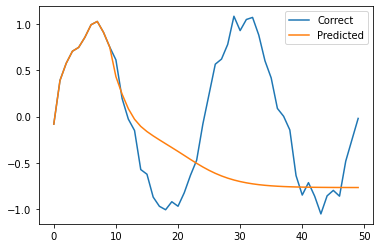

Epoch:11/101 Error:0.9196861975255304


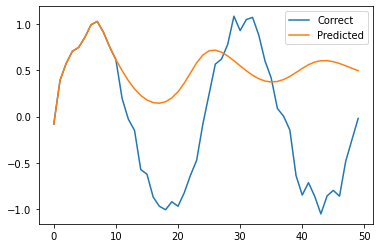

Epoch:21/101 Error:0.5803524031170487


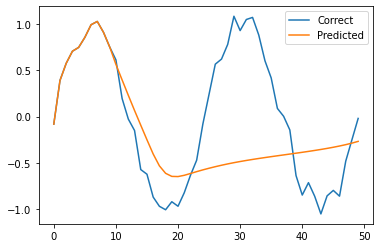

Epoch:31/101 Error:0.4654234061523732


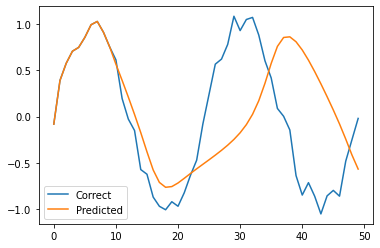

Epoch:41/101 Error:0.42182282269662097


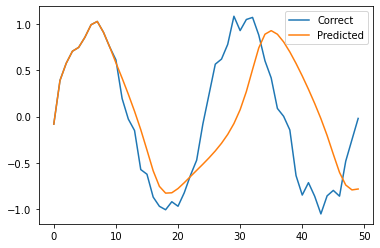

Epoch:51/101 Error:0.401795971463903


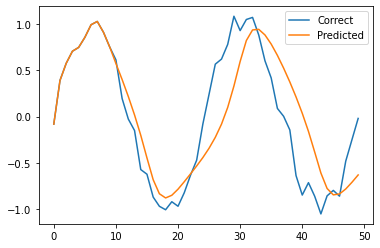

Epoch:61/101 Error:0.3904381588873919


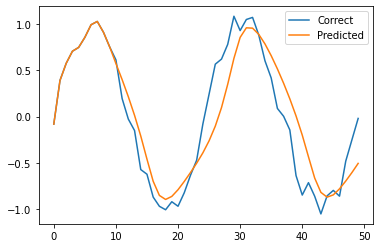

Epoch:71/101 Error:0.38374838085418084


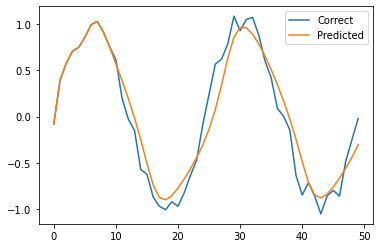

Epoch:81/101 Error:0.37544060645989663


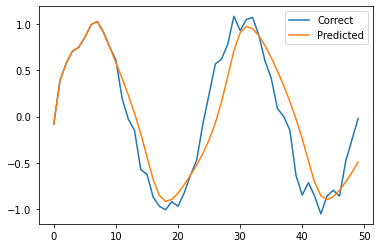

Epoch:91/101 Error:0.37154096275673426


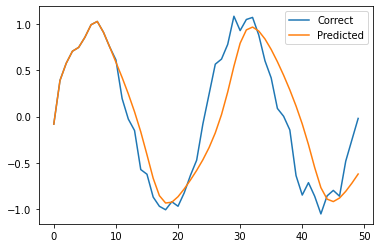

Epoch:101/101 Error:0.36684082080647595


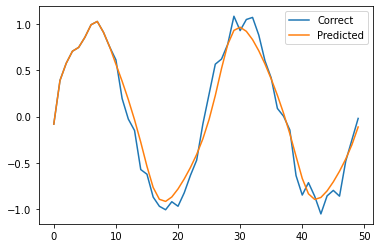

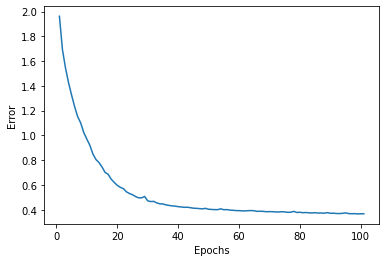

In [1]:
import numpy as np
# import cupy as np  # GPUの場合
import matplotlib.pyplot as plt

# -- 各設定値 --
n_time = 10  # 時系列の数
n_in = 1  # 入力層のニューロン数
n_mid = 20  # 中間層のニューロン数
n_out = 1  # 出力層のニューロン数

eta = 0.01  # 学習係数
epochs = 101
batch_size = 8
interval = 10  # 経過の表示間隔

def sigmoid(x):
    return 1/(1+np.exp(-x))

# -- 訓練データの作成 --
sin_x = np.linspace(-2*np.pi, 2*np.pi)  # -2πから2πまで
sin_y = np.sin(sin_x)  + 0.1*np.random.randn(len(sin_x))  # sin関数に乱数でノイズを加える
n_sample = len(sin_x)-n_time  # サンプル数
input_data = np.zeros((n_sample, n_time, n_in))  # 入力
correct_data = np.zeros((n_sample, n_out))  # 正解
for i in range(0, n_sample):
    input_data[i] = sin_y[i:i+n_time].reshape(-1, 1)
    correct_data[i] = sin_y[i+n_time:i+n_time+1]  # 正解は入力よりも一つ後

# -- GRU層 -- 
class GRULayer:
    def __init__(self, n_upper, n):
        # パラメータの初期値
        self.w = np.random.randn(3, n_upper, n) / np.sqrt(n_upper)  # Xavierの初期値
        self.v = np.random.randn(3, n, n) / np.sqrt(n)

    def forward(self, x, y_prev):
        a0 = sigmoid(np.dot(x, self.w[0]) + np.dot(y_prev, self.v[0]))  # 更新ゲート
        a1 = sigmoid(np.dot(x, self.w[1]) + np.dot(y_prev, self.v[1]))  # リセットゲート
        a2 = np.tanh(np.dot(x, self.w[2]) + np.dot(a1*y_prev, self.v[2]))  # 新しい記憶
        self.gates = np.stack((a0, a1, a2))

        self.y = (1-a0)*y_prev + a0*a2  # 出力
    
    def backward(self, x, y, y_prev, gates, grad_y):
        a0, a1, a2 = gates

        # 新しい記憶
        delta_a2 = grad_y * a0 * (1-a2**2)
        self.grad_w[2] += np.dot(x.T, delta_a2)
        self.grad_v[2] += np.dot((a1*y_prev).T, delta_a2)

        # 更新ゲート
        delta_a0 = grad_y * (a2-y_prev) * a0 * (1-a0)
        self.grad_w[0] += np.dot(x.T, delta_a0)
        self.grad_v[0] += np.dot(y_prev.T, delta_a0)

        # リセットゲート
        s = np.dot(delta_a2, self.v[2].T)
        delta_a1 = s * y_prev * a1 * (1-a1)
        self.grad_w[1] += np.dot(x.T, delta_a1)
        self.grad_v[1] += np.dot(y_prev.T, delta_a1)

        # xの勾配
        self.grad_x =  np.dot(delta_a0, self.w[0].T)
        + np.dot(delta_a1, self.w[1].T)
        + np.dot(delta_a2, self.w[2].T)

        # y_prevの勾配
        self.grad_y_prev = np.dot(delta_a0, self.v[0].T)
        + np.dot(delta_a1, self.v[1].T)
        + a1*s + grad_y*(1-a0)

    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v

# -- 全結合 出力層 --
class OutputLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # Xavierの初期値
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u  # 恒等関数

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)      
        self.grad_x = np.dot(delta, self.w.T) 

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

# -- 各層の初期化 --
gru_layer = GRULayer(n_in, n_mid)
output_layer = OutputLayer(n_mid, n_out)

# -- 訓練 --
def train(x_mb, t_mb):
    # 順伝播 GRU層
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    gates_rnn = np.zeros((3, len(x_mb), n_time, n_mid))
    y_prev = y_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        gru_layer.forward(x, y_prev)

        y = gru_layer.y
        y_rnn[:, i+1, :] = y
        y_prev = y

        gates = gru_layer.gates
        gates_rnn[:, :, i, :] = gates

    # 順伝播 出力層
    output_layer.forward(y)

    # 逆伝播 出力層
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x

    # 逆伝播 GRU層
    gru_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i+1, :]
        y_prev = y_rnn[:, i, :]
        gates = gates_rnn[:, :, i, :] 

        gru_layer.backward(x, y, y_prev, gates, grad_y)
        grad_y = gru_layer.grad_y_prev

    # パラメータの更新
    gru_layer.update(eta)
    output_layer.update(eta)

# -- 予測 --
def predict(x_mb):
    # 順伝播 GRU層
    y_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        gru_layer.forward(x, y_prev)
        y = gru_layer.y
        y_prev = y

    # 順伝播 出力層
    output_layer.forward(y)
    return output_layer.y

# -- 誤差を計算 --
def get_error(x, t):
    y = predict(x)
    return 1.0/2.0*np.sum(np.square(y - t))  # 二乗和誤差

error_record = []
n_batch = len(input_data) // batch_size  # 1エポックあたりのバッチ数
for i in range(epochs):
        
    # -- 学習 -- 
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)  # インデックスをシャッフルする
    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = input_data[mb_index, :]
        t_mb = correct_data[mb_index, :]
        train(x_mb, t_mb)

    # -- 誤差を求める --
    error = get_error(input_data, correct_data)
    error_record.append(error)

    # -- 経過の表示 -- 
    if i%interval == 0:
        print("Epoch:"+str(i+1)+"/"+str(epochs), "Error:"+str(error))

        predicted = input_data[0].reshape(-1).tolist() # 最初の入力
        for i in range(n_sample):
            x = np.array(predicted[-n_time:]).reshape(1, n_time, 1)
            y = predict(x)
            predicted.append(float(y[0, 0]))  # 出力をpredictedに追加する

        plt.plot(range(len(sin_y)), sin_y.tolist(), label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()

plt.plot(range(1, len(error_record)+1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()